In [23]:
# Python set up
import warnings
import itertools
# from pandas import datetime
from pandas import read_csv
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot') 
import seaborn as sns  
sns.set(style="whitegrid")

## Examine data

In [24]:
df = pd.read_csv("../data/data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

# Assign a frequency to the index
df = df.asfreq('D')  # Example: 'D' for daily frequency
# Adjust Frequency Based on Your Data
#     'D': Daily frequency.
#     'M': Monthly frequency.
#     'W': Weekly frequency.
#     'B': Business day frequency.
# # Fill missing dates with forward-fill
# df = df.asfreq('D').fillna(method='ffill')

# Chỉ quan tâm đến cột Adj Close
# data = df['Adj Close']

df.head()

,Adj Close
Date,
1960-01-04,4.52
1960-01-05,4.55
1960-01-06,4.68
1960-01-07,4.63
1960-01-08,4.59


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16229 entries, 1960-01-04 to 2024-11-08
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  16229 non-null  float64
dtypes: float64(1)
memory usage: 253.6 KB


In [9]:
df.index

DatetimeIndex(['1960-01-04', '1960-01-05', '1960-01-06', '1960-01-07',
               '1960-01-08', '1960-01-11', '1960-01-12', '1960-01-13',
               '1960-01-14', '1960-01-15',
               ...
               '2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31',
               '2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06',
               '2024-11-07', '2024-11-08'],
              dtype='datetime64[ns]', name='Date', length=16229, freq=None)

### Plot the data

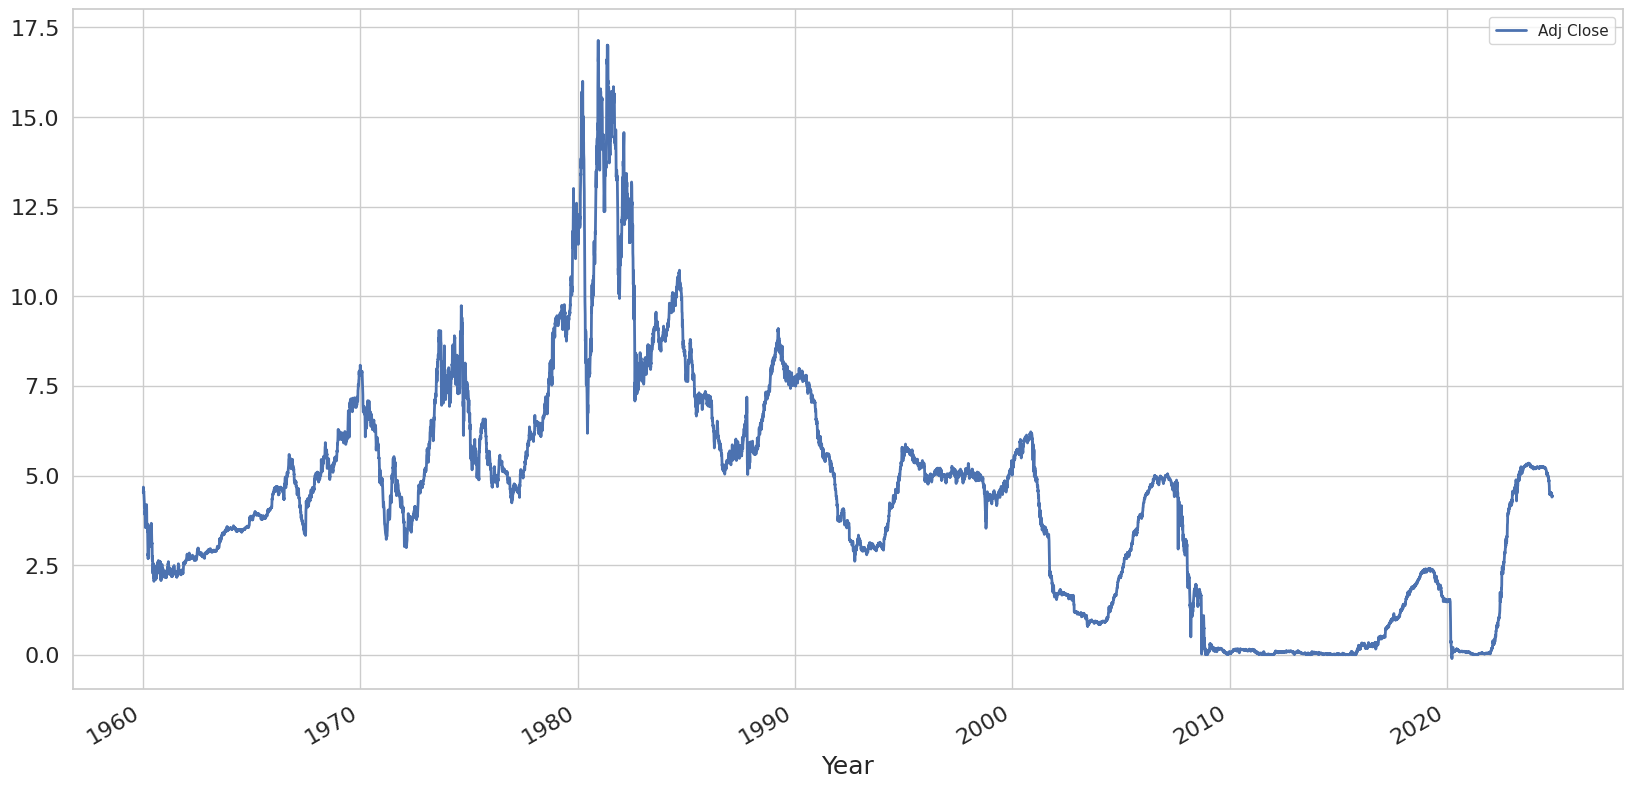

In [10]:
df.plot(figsize=(20,10), linewidth=2, fontsize=16)
plt.xlabel('Year', fontsize=18);


Trend phuc tap, ton tai cac xu the ngan han nhung ve dai han khong ro trend. Co the ton tai tinh chat chu ky.

## Decompose data

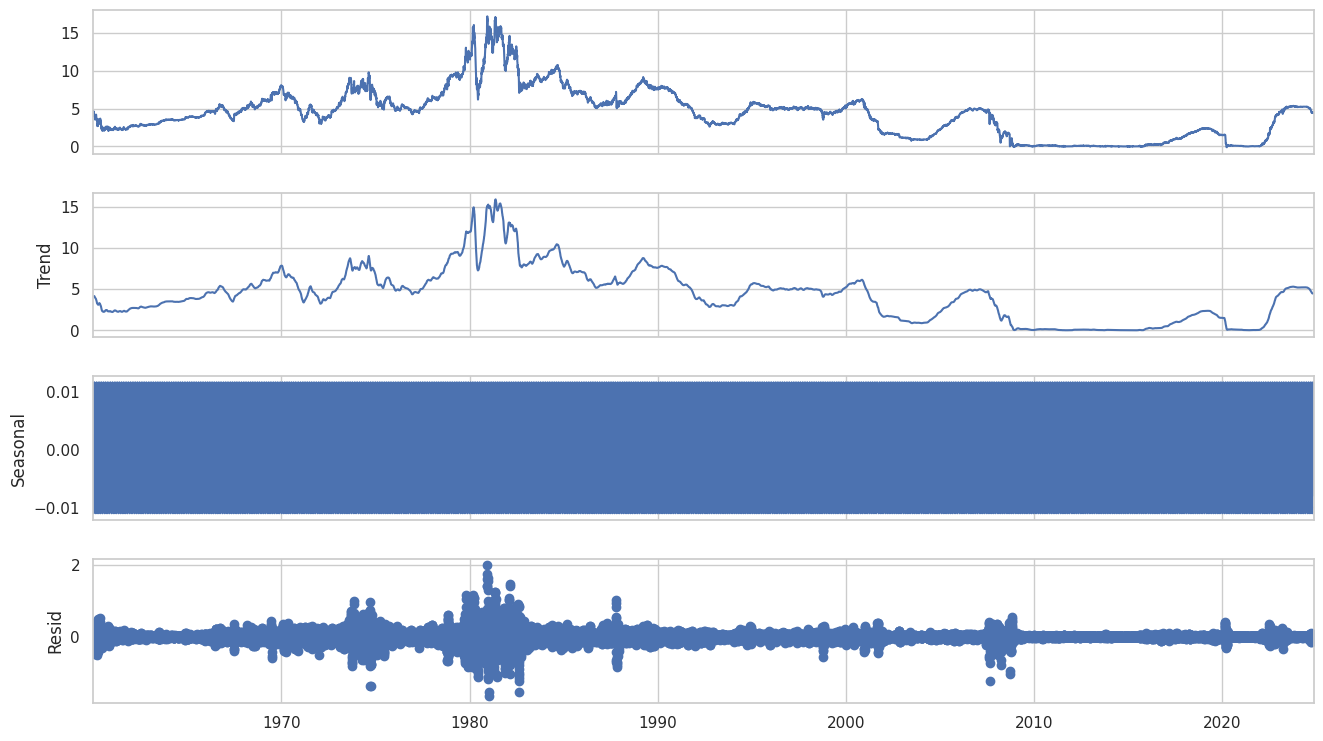

In [15]:
decomposition = seasonal_decompose(df, model='additive', period=30); 
fig = decomposition.plot();
fig.set_size_inches(15, 8);

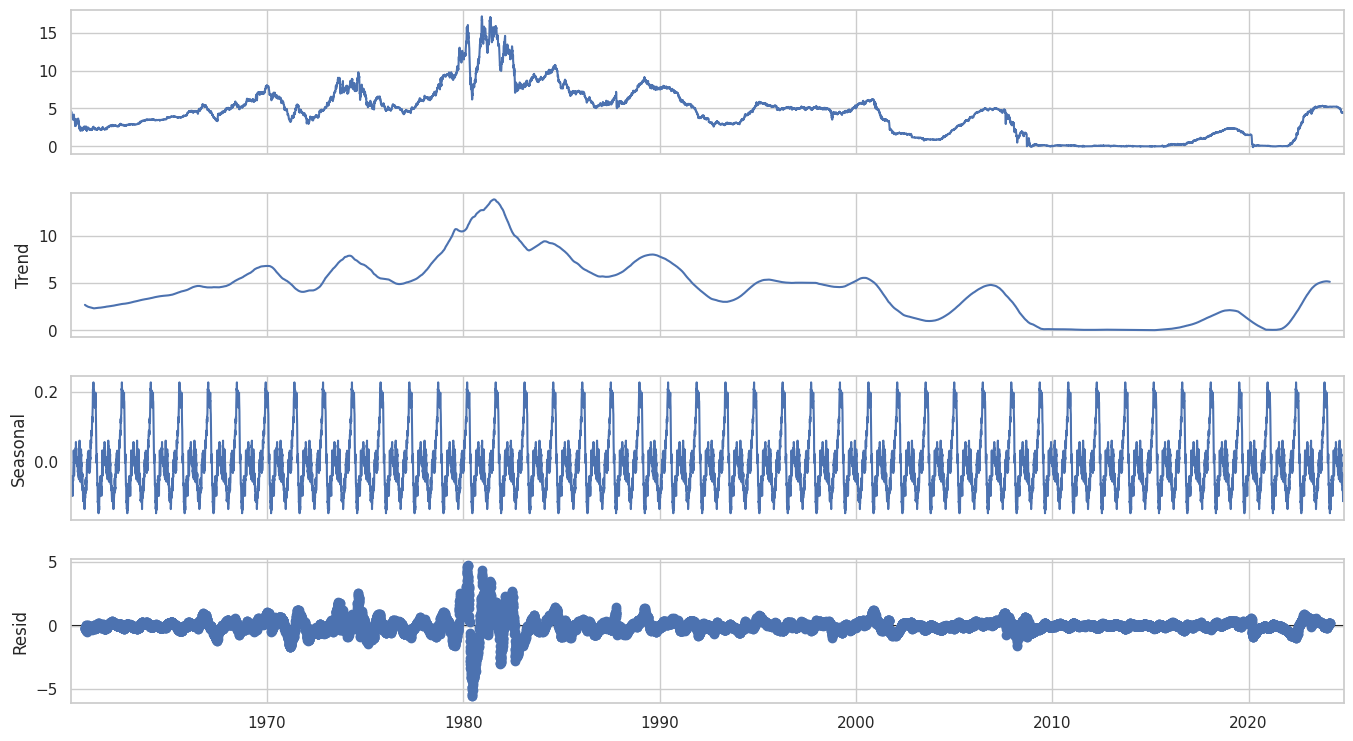

In [13]:
decomposition = seasonal_decompose(df, model='additive', period=365); 
fig = decomposition.plot();
fig.set_size_inches(15, 8);

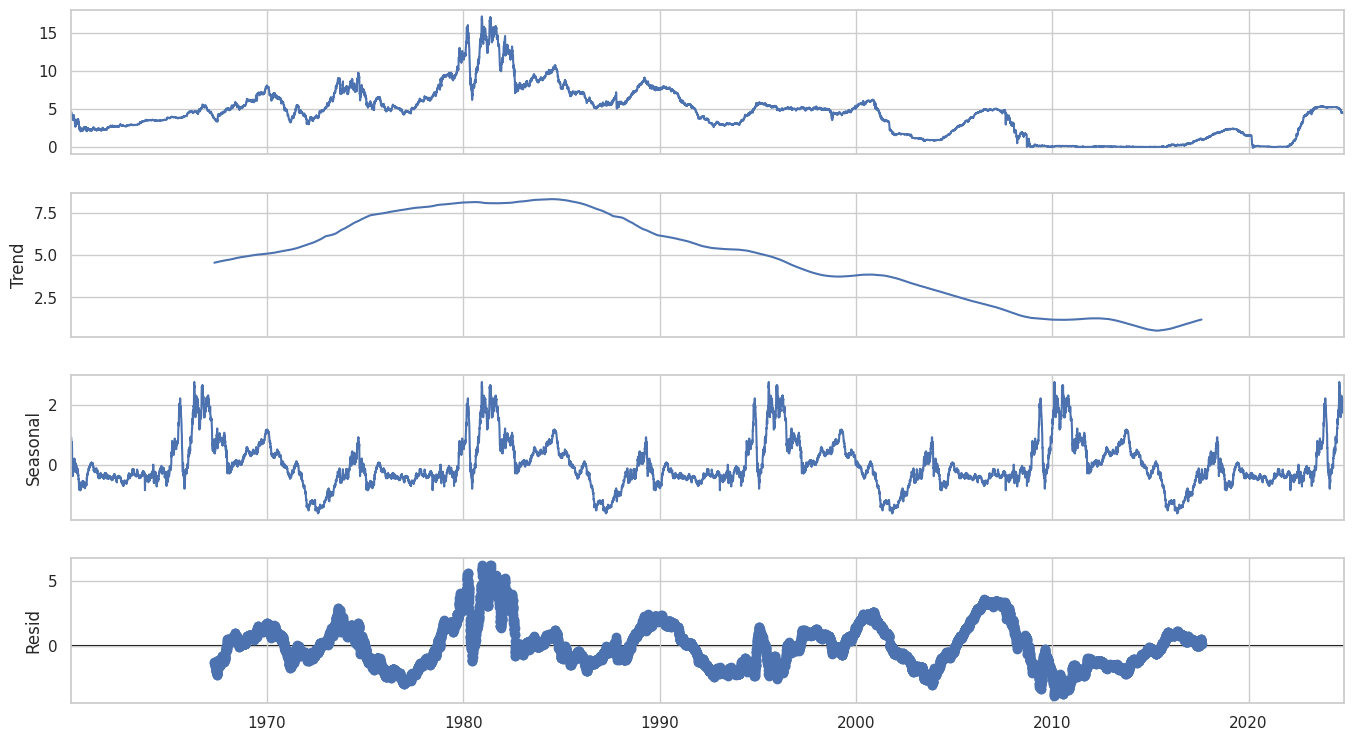

In [16]:
decomposition = seasonal_decompose(df, model='additive', period=3650); 
fig = decomposition.plot();
fig.set_size_inches(15, 8);

## Stationarity

In [17]:
# ADF Test with better readable output
result = adfuller(df['Adj Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.340499287985867
p-value: 0.15923852249623738
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Chuoi khong dung

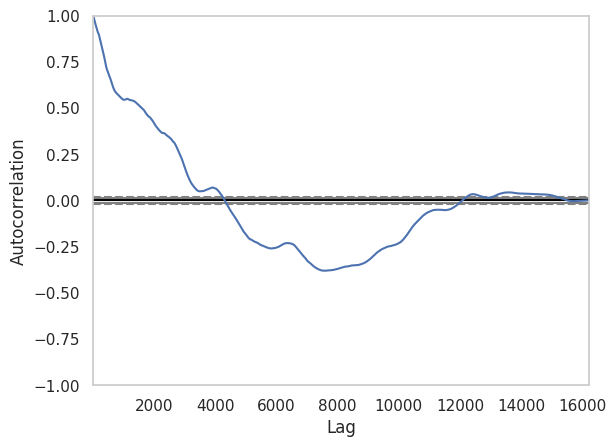

In [20]:
autocorrelation_plot(df);

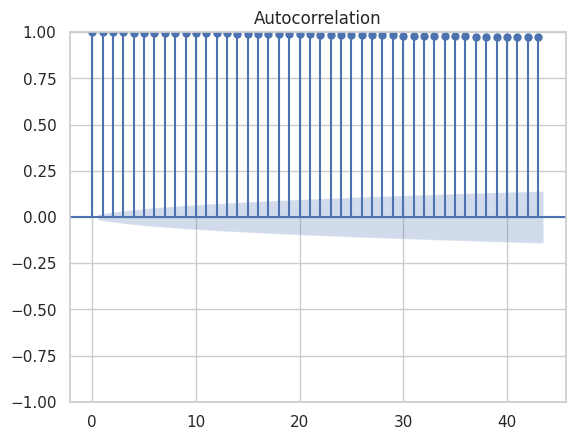

In [33]:
plot_acf(df);

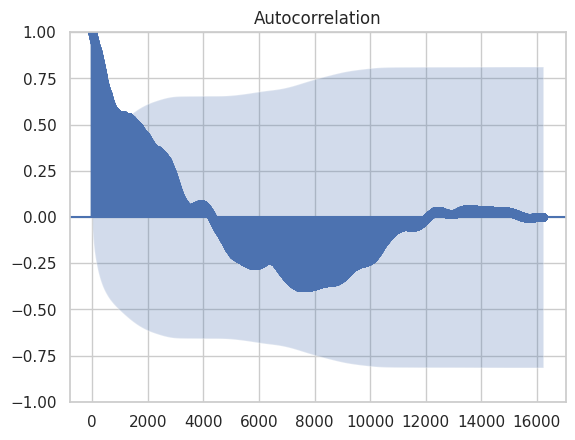

In [24]:
plot_acf(df, lags=16228);

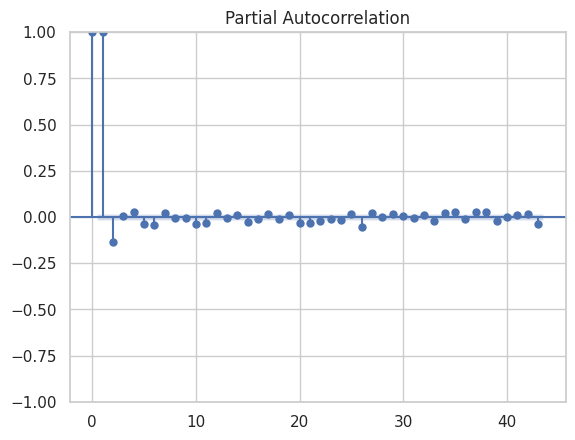

In [27]:
plot_pacf(df);

---

Diff 1

In [32]:
# plot_pacf(df, lags=8114);

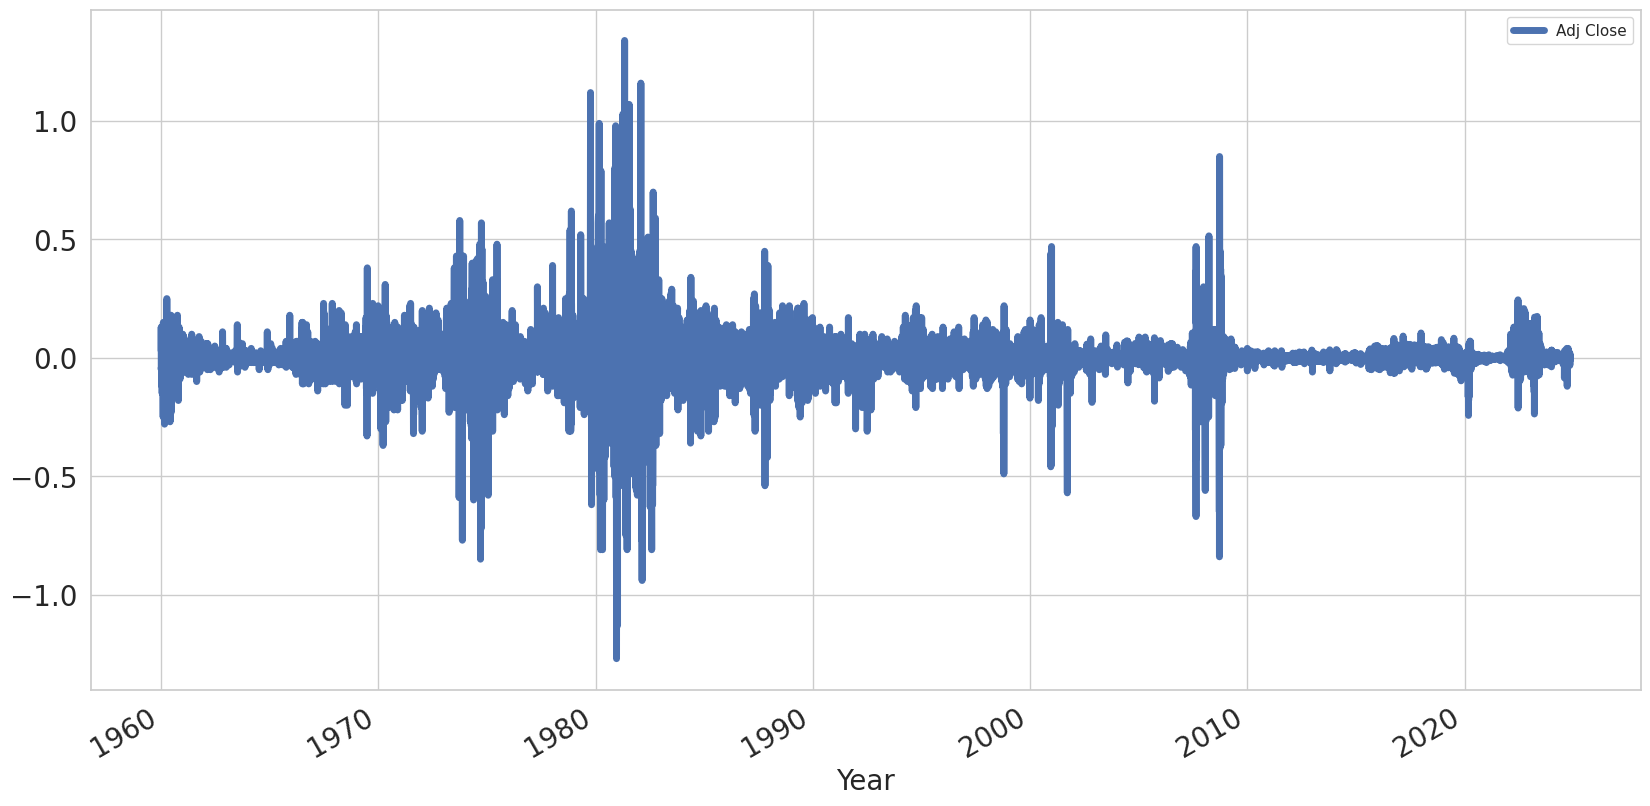

In [18]:
df.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

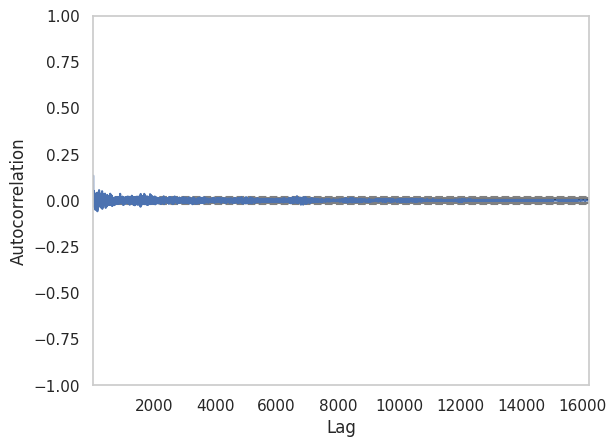

In [21]:
autocorrelation_plot(df.diff().dropna());

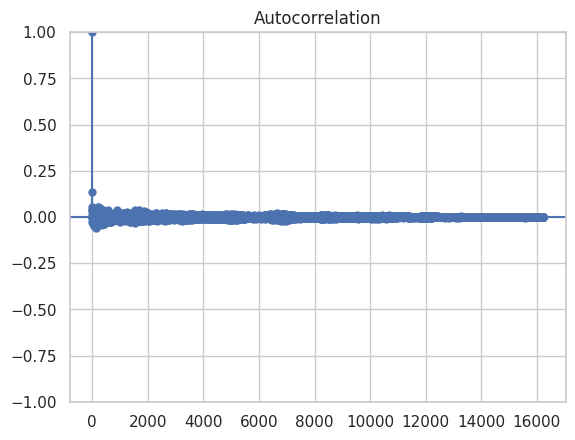

In [26]:
plot_acf(df.diff().dropna(), lags=16227);

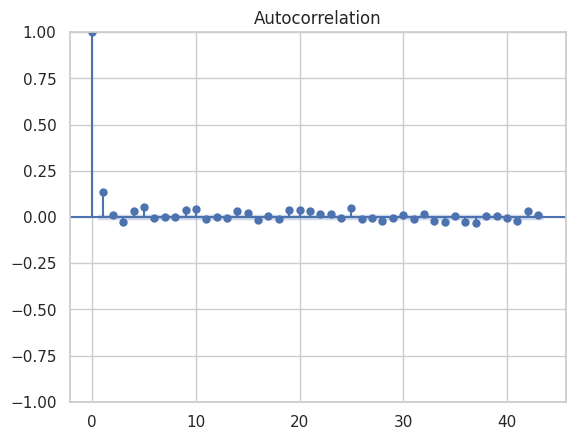

In [34]:
plot_acf(df.diff().dropna());

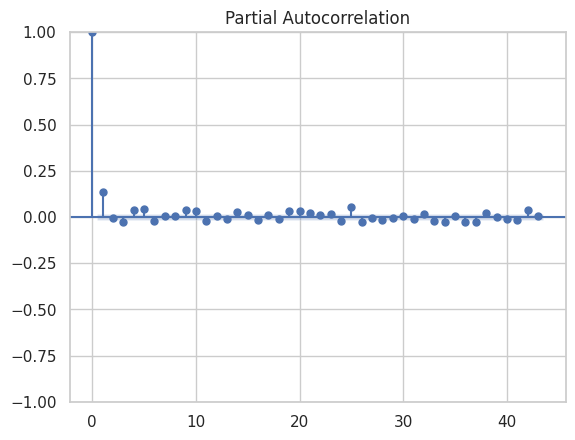

In [35]:
plot_pacf(df.diff().dropna());

---

Diff 2

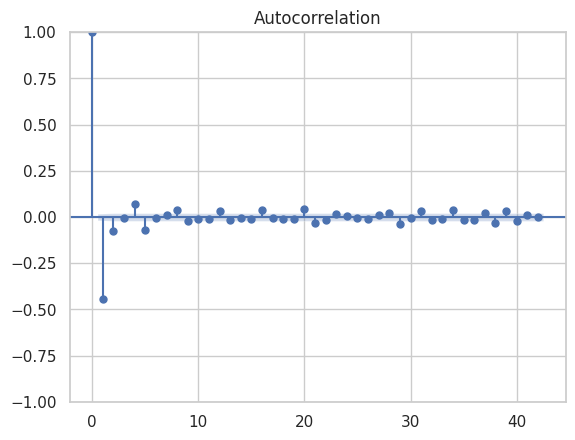

In [42]:
plot_acf(df.diff().dropna().diff().dropna());

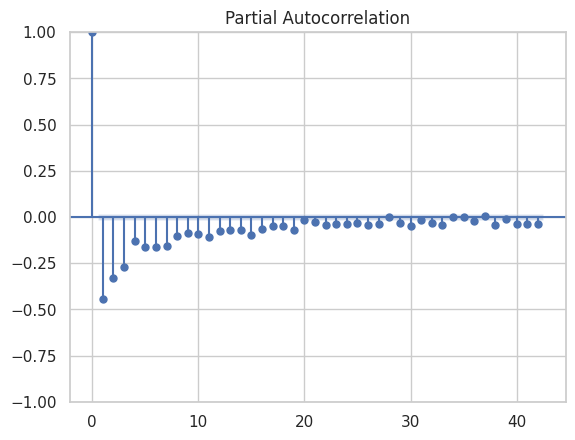

In [43]:
plot_pacf(df.diff().dropna().diff().dropna());

## Fitting an model

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.api import qqplot
import matplotlib.pyplot as plt

# Kiểm tra tính dừng của chuỗi
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, alpha=0.05):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < alpha:
        print("Chuỗi dừng (p-value < alpha).")
    else:
        print("Chuỗi không dừng (p-value >= alpha).")

def plot_acf_pacf(series, lags=40):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(series.dropna(), lags=lags, ax=ax[0])
    plot_pacf(series.dropna(), lags=lags, ax=ax[1])
    plt.show()

def plot_residuals(residuals):
    # Ljung-Box test để kiểm tra tự tương quan dư
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("\nLjung-Box Test Results:")
    print(lb_test)
    
    # Đồ thị phân tích dư sai
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Đồ thị dư sai
    axes[0].plot(residuals, color='blue')
    axes[0].axhline(0, linestyle='--', color='red')
    axes[0].set_title('Residuals')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Residuals')
    
    # Biểu đồ histogram dư sai
    axes[1].hist(residuals, bins=30, color='gray', edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].set_title('Residuals Histogram')
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    
    # QQ-plot để kiểm tra phân phối chuẩn
    qqplot(residuals, line='s', ax=axes[2])
    axes[2].set_title('Residuals QQ-Plot')
    
    # Hiển thị đồ thị
    plt.tight_layout()
    plt.show()


In [5]:
# Kiểm tra chuỗi ban đầu và sau sai phân
check_stationarity(df['Adj Close'])

ADF Statistic: -2.340499287985867
p-value: 0.15923852249623738
Chuỗi không dừng (p-value >= alpha).


In [4]:
# Sai phân nếu chuỗi không dừng
df['Adj Close_diff'] = df['Adj Close'].diff().dropna()
check_stationarity(df['Adj Close_diff'])

ADF Statistic: -16.18212434608183
p-value: 4.25567914802795e-29
Chuỗi dừng (p-value < alpha).


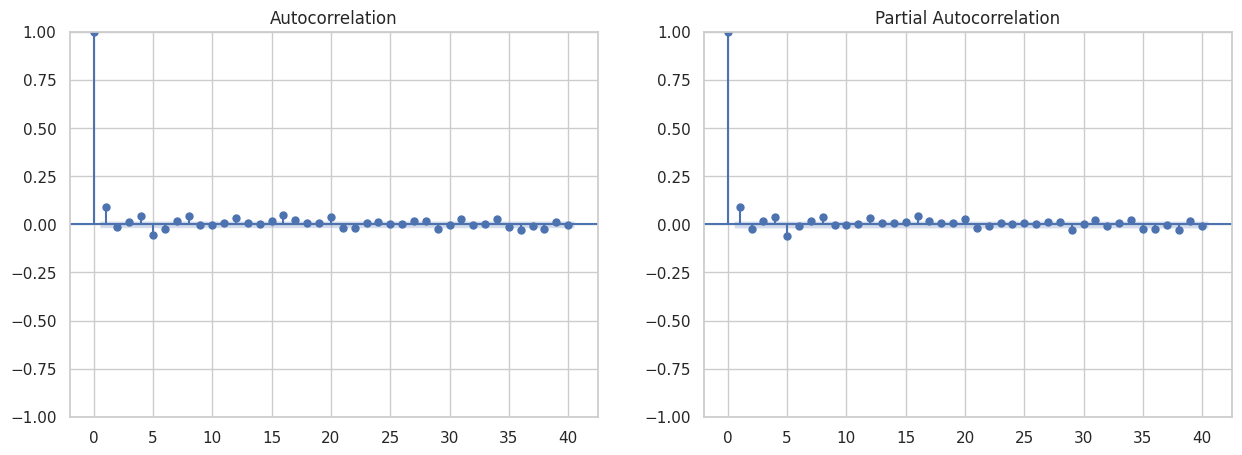

In [50]:
plot_acf_pacf(df['Adj Close_diff'])

In [25]:
# Fit mô hình ARIMA
model = ARIMA(df['Adj Close'].dropna(), order=(2, 1, 2))
results = model.fit()

# Hiển thị tóm tắt kết quả
print(results.summary())

# Kiểm tra dư sai
residuals = results.resid.dropna()

# Đồ thị dư sai
plot_residuals(residuals)



NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                23686
Model:                 ARIMA(2, 1, 2)   Log Likelihood               16757.377
Date:                Tue, 19 Nov 2024   AIC                         -33504.754
Time:                        19:09:22   BIC                         -33464.391
Sample:                    01-04-1960   HQIC                        -33491.656
                         - 11-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0106      0.546     -1.851      0.064      -2.080       0.059
ar.L2         -0.1880      0.188     -1.002      0.316      -0.556       0.180
ma.L1          1.0982      0.546      2.011      0.0

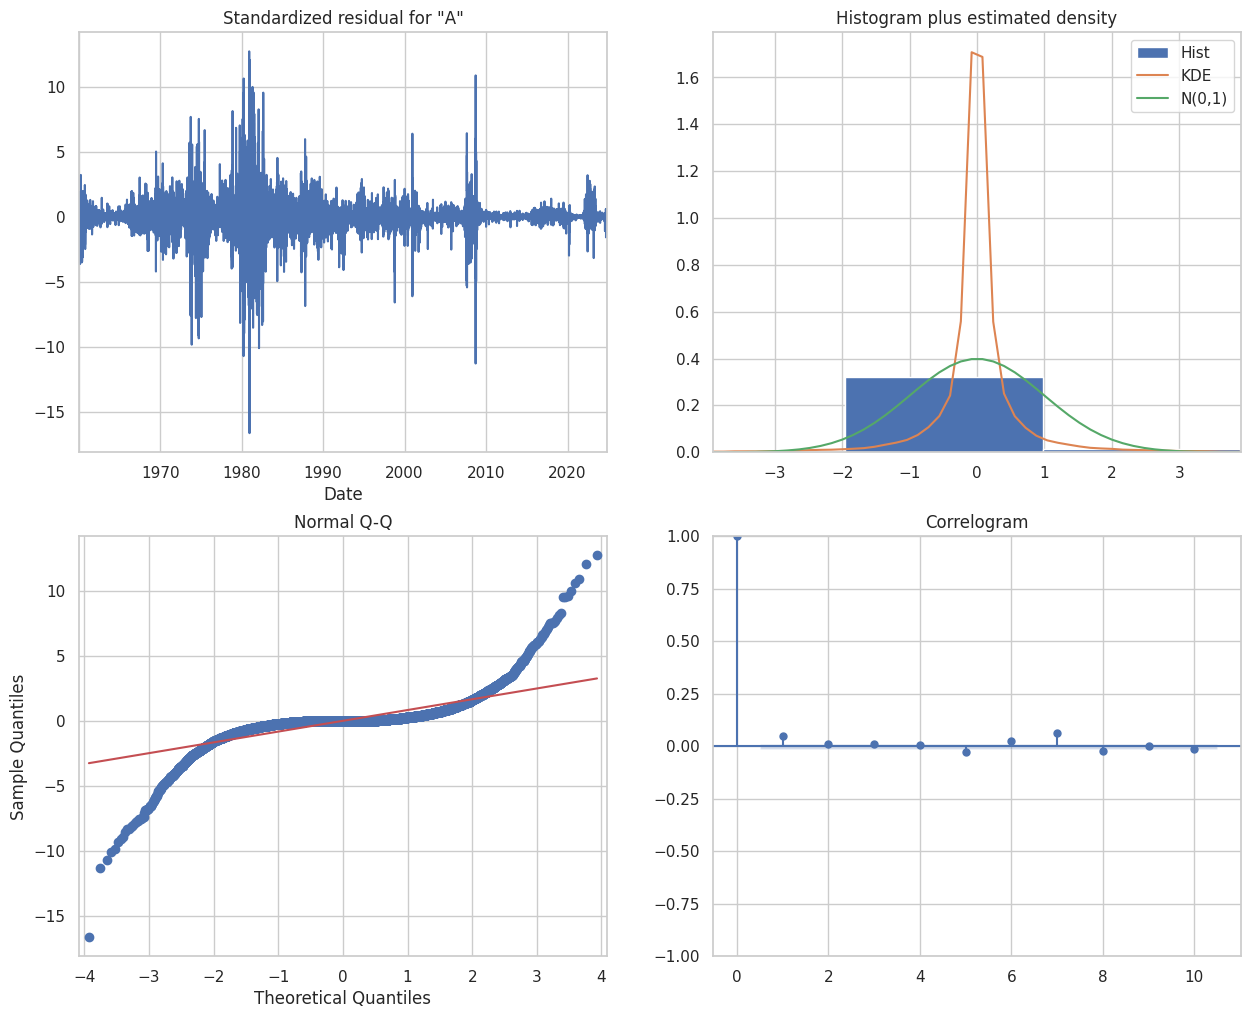

In [7]:
# Fit mô hình ARIMA
model = ARIMA(df['Adj Close'], order=(2, 1, 2))
results = model.fit()

# Hiển thị tóm tắt kết quả
print(results.summary())

# Kiểm tra dư sai
residuals = results.resid

results.plot_diagnostics(figsize=(15, 12))
plt.show()

Phân tích kết quả **SARIMAX Results** từ mô hình **ARIMA(2, 1, 2)**:

### 1. **Thông tin chung về mô hình**
- **Dep. Variable**: Biến phụ thuộc trong mô hình là `Adj Close` (giá điều chỉnh đóng cửa của chuỗi thời gian).
- **No. Observations**: Tổng số quan sát (23686).
- **Model**: Mô hình sử dụng là ARIMA với thông số \(p=2, d=1, q=2\).
- **Log Likelihood**: Log-likelihood của mô hình là 16757.377, đại diện cho mức độ khớp của mô hình (giá trị càng cao càng tốt).
- **AIC (Akaike Information Criterion)**: \(-33504.754\), dùng để đánh giá chất lượng của mô hình (giá trị càng nhỏ càng tốt).
- **BIC (Bayesian Information Criterion)**: \(-33464.391\), cũng là một chỉ số đánh giá mô hình (nhỏ hơn tốt hơn nhưng phạt cao hơn với mô hình phức tạp).
- **HQIC (Hannan-Quinn Information Criterion)**: \(-33491.656\), tương tự AIC và BIC.

### 2. **Hệ số ước lượng của mô hình**
| **Hệ số** | **Giá trị** | **Std. Err** | **P-value** | **Ý nghĩa** |
|-----------|-------------|--------------|-------------|-------------|
| **ar.L1** | -1.0106     | 0.546        | 0.064       | Hệ số không có ý nghĩa ở mức 5%, nhưng gần với mức ý nghĩa.|
| **ar.L2** | -0.1880     | 0.188        | 0.316       | Không có ý nghĩa thống kê (P > 0.05). |
| **ma.L1** | 1.0982      | 0.546        | 0.044       | Có ý nghĩa thống kê ở mức 5% (P < 0.05). |
| **ma.L2** | 0.2518      | 0.234        | 0.282       | Không có ý nghĩa thống kê. |
| **sigma2**| 0.0057      | 1.73e-05     | 0.000       | Phương sai nhiễu rất nhỏ và có ý nghĩa thống kê. |

- **Ý nghĩa**: 
  - Các tham số autoregressive (AR) và moving average (MA) cho thấy ảnh hưởng của các độ trễ khác nhau trong chuỗi. Tuy nhiên, chỉ có hệ số \(ma.L1\) là thực sự đáng kể với mức ý nghĩa 5%.
  - Hệ số \(\sigma^2\) (phương sai của nhiễu) rất nhỏ, cho thấy nhiễu trong mô hình được kiểm soát tốt.

### 3. **Chẩn đoán mô hình**
- **Ljung-Box (Q)**: Giá trị kiểm định \(Q = 54.07\) với \(p=0.00\), cho thấy mô hình có thể chưa hoàn toàn loại bỏ được tự tương quan dư (serial correlation) ở độ trễ 1.
- **Jarque-Bera (JB)**: Giá trị \(1908074.63\) với \(p=0.00\), cho thấy dư sai không tuân theo phân phối chuẩn (vì \(p\)-value rất nhỏ).
- **Heteroskedasticity (H)**: Giá trị \(H=0.15\) với \(p=0.00\), cho thấy tồn tại hiện tượng phương sai không đồng nhất (heteroskedasticity).
- **Skewness**: Chuỗi có độ lệch phân phối hơi âm (-0.56).
- **Kurtosis**: Giá trị \(46.96\), rất lớn, cho thấy chuỗi có đuôi dài (leptokurtic).

### 4. **Kết luận từ kết quả**
- Mô hình ARIMA(2, 1, 2) có khả năng khớp tương đối tốt (Log-likelihood cao, AIC/BIC thấp). Tuy nhiên:
  - Chỉ một số hệ số AR/MA là có ý nghĩa thống kê.
  - Chuỗi dư sai không tuân theo phân phối chuẩn, và tồn tại phương sai không đồng nhất.
  - Mô hình có thể cần cải thiện thêm, chẳng hạn:
    - Kiểm tra và loại bỏ tự tương quan dư (residual autocorrelation).
    - Xem xét các phương pháp chuyển đổi chuỗi thời gian (log, differencing nhiều lần).
    - Sử dụng mô hình khác như SARIMA, GARCH, hoặc các kỹ thuật phi tuyến (LSTM, Prophet).

---

Diff 2

ADF Statistic: -15.287931442217335
p-value: 4.484192583306829e-28
Chuỗi dừng (p-value < alpha).


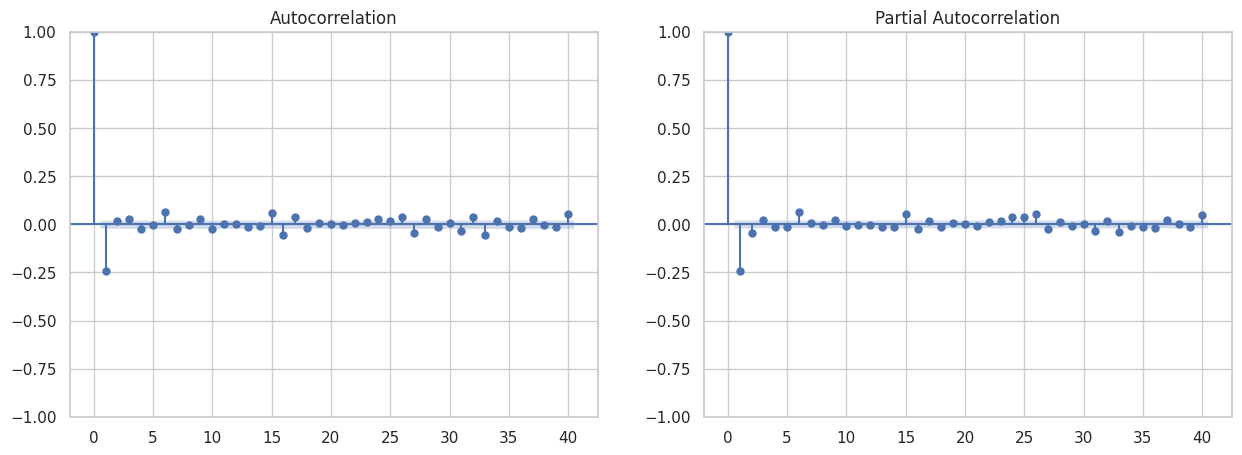

In [5]:
df['Adj Close_diff2'] = df['Adj Close_diff'].diff().dropna()
check_stationarity(df['Adj Close_diff2'])
plot_acf_pacf(df['Adj Close_diff2'])

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                23686
Model:                 ARIMA(2, 2, 2)   Log Likelihood               16749.379
Date:                Tue, 19 Nov 2024   AIC                         -33488.758
Time:                        19:10:24   BIC                         -33448.395
Sample:                    01-04-1960   HQIC                        -33475.659
                         - 11-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9183      0.003   -276.596      0.000      -0.925      -0.912
ar.L2          0.0815      0.003     25.406      0.000       0.075       0.088
ma.L1      -8.208e-06      0.008     -0.001      0.9

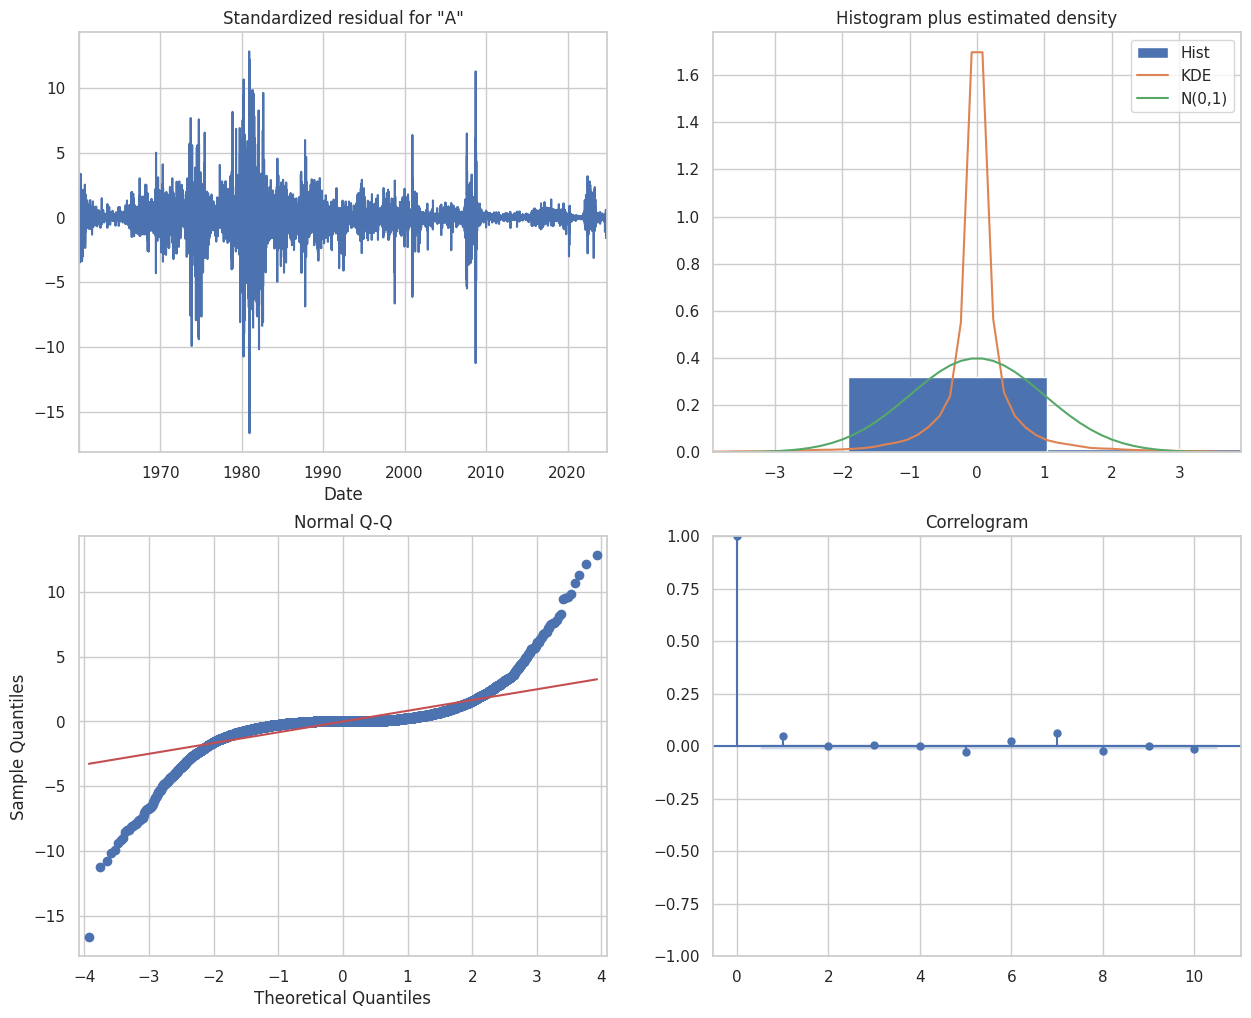

In [9]:
# Fit mô hình ARIMA
model = ARIMA(df['Adj Close'], order=(2, 2, 2))
results = model.fit()

# Hiển thị tóm tắt kết quả
print(results.summary())

# Kiểm tra dư sai
residuals = results.resid

# Đồ thị dư sai
# plot_residuals(residuals)

results.plot_diagnostics(figsize=(15, 12))
plt.show()

Dưới đây là phân tích chi tiết về kết quả từ **SARIMAX Results** với mô hình **ARIMA(2, 2, 2)**:

---

### 1. **Thông tin chung về mô hình**
- **Dep. Variable**: Biến phụ thuộc là `Adj Close` (giá điều chỉnh đóng cửa).
- **No. Observations**: Số lượng quan sát là 23,686.
- **Model**: Mô hình sử dụng là ARIMA(2, 2, 2), trong đó:
  - \(p=2\): Hai độ trễ autoregressive.
  - \(d=2\): Sai phân bậc hai để đảm bảo chuỗi dừng.
  - \(q=2\): Hai độ trễ của moving average.
- **Log Likelihood**: Giá trị log-likelihood là 16,749.379 (giảm nhẹ so với ARIMA(2, 1, 2)).
- **AIC**: \(-33488.758\), cao hơn một chút so với mô hình ARIMA(2, 1, 2).
- **BIC**: \(-33448.395\), cũng tăng nhẹ, cho thấy mô hình này phức tạp hơn.
- **HQIC**: \(-33475.659\), tương tự.

---

### 2. **Hệ số ước lượng**
| **Hệ số** | **Giá trị** | **Std. Err** | **z**       | **P-value** | **Ý nghĩa** |
|-----------|-------------|--------------|-------------|-------------|-------------|
| **ar.L1** | -0.9183     | 0.003        | -276.596    | 0.000       | Có ý nghĩa thống kê.|
| **ar.L2** | 0.0815      | 0.003        | 25.406      | 0.000       | Có ý nghĩa thống kê. |
| **ma.L1** | -8.208e-06  | 0.008        | -0.001      | 0.999       | Không có ý nghĩa thống kê. |
| **ma.L2** | -1.0000     | 0.008        | -120.987    | 0.000       | Có ý nghĩa thống kê. |
| **sigma2**| 0.0057      | 4.44e-05     | 127.374     | 0.000       | Phương sai nhiễu nhỏ và có ý nghĩa thống kê. |

- **Phân tích**:
  - \(ar.L1\) và \(ar.L2\): Hệ số autoregressive đều có ý nghĩa thống kê cao (\(p\)-value < 0.05).
  - \(ma.L1\): Hệ số moving average bậc 1 không có ý nghĩa thống kê (\(p = 0.999\)).
  - \(ma.L2\): Hệ số moving average bậc 2 có ý nghĩa thống kê cao.
  - \(sigma^2\): Phương sai của nhiễu là rất nhỏ, điều này tốt cho mô hình hóa.

---

### 3. **Chẩn đoán mô hình**
- **Ljung-Box (Q)**: Giá trị \(Q = 58.61\) với \(p=0.00\), chỉ ra rằng vẫn còn tự tương quan dư ở độ trễ 1 (giống mô hình trước đó).
- **Jarque-Bera (JB)**: Giá trị rất lớn (\(1926496.01\), \(p=0.00\)), cho thấy dư sai không tuân theo phân phối chuẩn.
- **Heteroskedasticity (H)**: Giá trị \(H=0.15\) với \(p=0.00\), chỉ ra tồn tại phương sai không đồng nhất (heteroskedasticity).
- **Skewness**: Độ lệch phân phối hơi âm (-0.57).
- **Kurtosis**: Giá trị cao (\(47.17\)), chuỗi có đuôi dài (leptokurtic).

---

### 4. **Cảnh báo**
1. **Covariance matrix**:
   - Cảnh báo "[Covariance matrix is singular or near-singular]":
     - Điều này có thể do các biến có mối tương quan cao hoặc dư sai không được mô hình hóa tốt.
     - Hệ số \(ma.L1\) không ý nghĩa thống kê có thể góp phần vào vấn đề này.
   - Điều này có thể dẫn đến **standard errors không ổn định**, ảnh hưởng đến kết luận thống kê.

---

### 5. **So sánh với ARIMA(2, 1, 2)**
- **AIC/BIC cao hơn**: ARIMA(2, 2, 2) phức tạp hơn nhưng không cải thiện nhiều về chất lượng mô hình.
- **Hệ số \(ma.L1\) không ý nghĩa**: ARIMA(2, 2, 2) có thể chưa phải lựa chọn tối ưu.
- **Chuỗi dừng bậc 1 (d=1)** trong ARIMA(2, 1, 2) có vẻ phù hợp hơn so với \(d=2\).

---

### 6. **Kết luận**
- ARIMA(2, 2, 2) không vượt trội so với ARIMA(2, 1, 2).
- Các vấn đề cần khắc phục:
  - Loại bỏ tự tương quan dư (sử dụng kiểm định ACF/PACF để chọn tham số \(p, q\) tối ưu hơn).
  - Giảm phương sai không đồng nhất bằng cách kiểm tra các phép biến đổi như log hoặc square root.
  - Nếu vấn đề không được giải quyết tốt, hãy cân nhắc các mô hình phi tuyến như SARIMA hoặc GARCH.

Có thể cần kiểm tra lại **ACF/PACF** để tối ưu hóa tham số \(p, q\), hoặc thử nghiệm với \(d=1\) thay vì \(d=2\).

---


### SARIMAX-Model

When looking to fit time series data with a **seasonal** ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. We could use the above described procedere or resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

---

Sources: 

[Statsmodel Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

In [10]:
# Grid search to find the best

# Define the p, d and q parameters 
# In our example, we only take values between 0 and 2 to make the computation faster
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print(pdq.__len__(), seasonal_pdq.__len__())

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 365)
SARIMAX: (0, 0, 1) x (0, 0, 2, 365)
SARIMAX: (0, 0, 2) x (0, 1, 0, 365)
SARIMAX: (0, 0, 2) x (0, 1, 1, 365)
27 27


In [5]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages
import sys

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = smf.tsa.statespace.SARIMAX(
#                 df['Adj Close'],
#                 order=param,
#                 seasonal_order=param_seasonal,
#                 enforce_stationarity=False,
#                 enforce_invertibility=False,
#             )
#             results = mod.fit()
#             print("ARIMA{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
#         except:
#             print("Unexpected error:", sys.exc_info()[0])
#             continue

param = (2, 1, 2)
param_seasonal = (2, 1, 2, 7) # take (2, 1, 2, 365) is too slow
mod = smf.tsa.statespace.SARIMAX(
    df['Adj Close'],
    order=param,
    seasonal_order=param_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = mod.fit()
print("ARIMA{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.97800D-01    |proj g|=  6.62948D-01


 This problem is unconstrained.



At iterate    5    f= -6.43372D-01    |proj g|=  3.25690D-01

At iterate   10    f= -7.10326D-01    |proj g|=  2.91415D-01

At iterate   15    f= -7.15130D-01    |proj g|=  1.58357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     31      1     0     0   2.720D-03  -7.151D-01
  F = -0.71513027653543038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 2, 7)12 - AIC:-33859.15146003641


                                     SARIMAX Results                                     
Dep. Variable:                         Adj Close   No. Observations:                23686
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               16938.576
Date:                           Tue, 19 Nov 2024   AIC                         -33859.151
Time:                                   19:19:44   BIC                         -33786.507
Sample:                               01-04-1960   HQIC                        -33835.577
                                    - 11-08-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4422      0.662      0.667      0.504      -0.856       1.741
ar.L2         -0.0418      0.120     -0.349

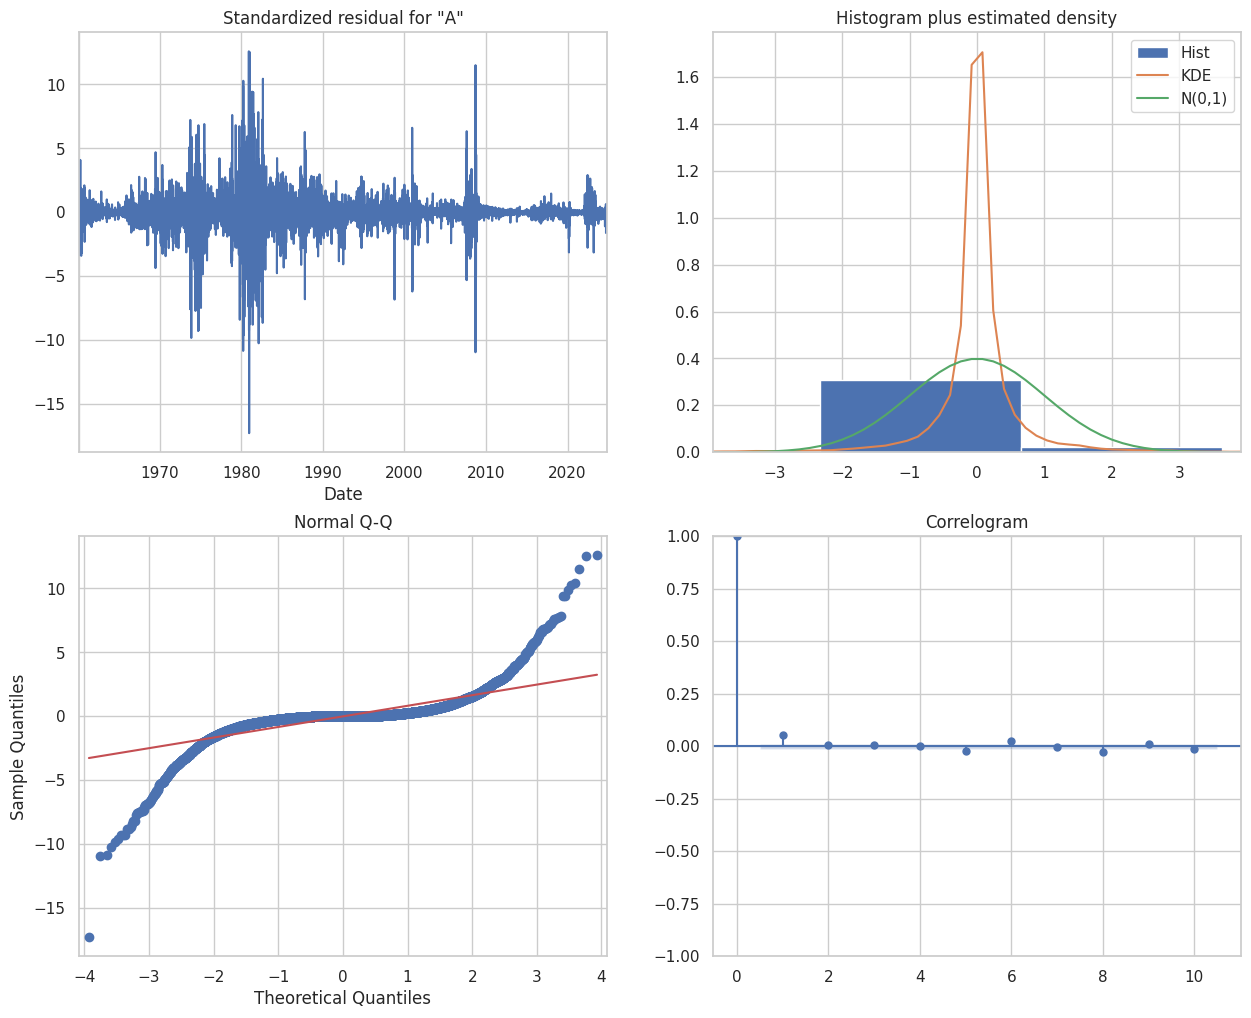

In [6]:
print(results.summary()) #.tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

---

MA the data


In [6]:
# Calculate Cumulative Moving Average (CMA) with a window of 30
df['CMA30'] = df['Adj Close'].expanding().mean()

# Calculate Exponential Moving Average (EWMA) with a span of 30
df['EWMA30'] = df['Adj Close'].ewm(span=30).mean()

# Print DataFrame
df

,Adj Close,Adj Close_diff,Adj Close_diff2,CMA30,EWMA30
Date,,,,,
1960-01-04,4.520,NaN,NaN,4.520000,4.520000
1960-01-05,4.550,0.030,NaN,4.535000,4.535500
1960-01-06,4.680,0.130,0.099999,4.583333,4.586912
1960-01-07,4.630,-0.050,-0.179999,4.595000,4.598785
1960-01-08,4.590,-0.040,0.010000,4.594000,4.596786
...,...,...,...,...,...
2024-11-04,4.418,NaN,NaN,4.361710,4.495677
2024-11-05,4.423,0.005,NaN,4.361713,4.489036
2024-11-06,4.430,0.007,0.002000,4.361718,4.483783


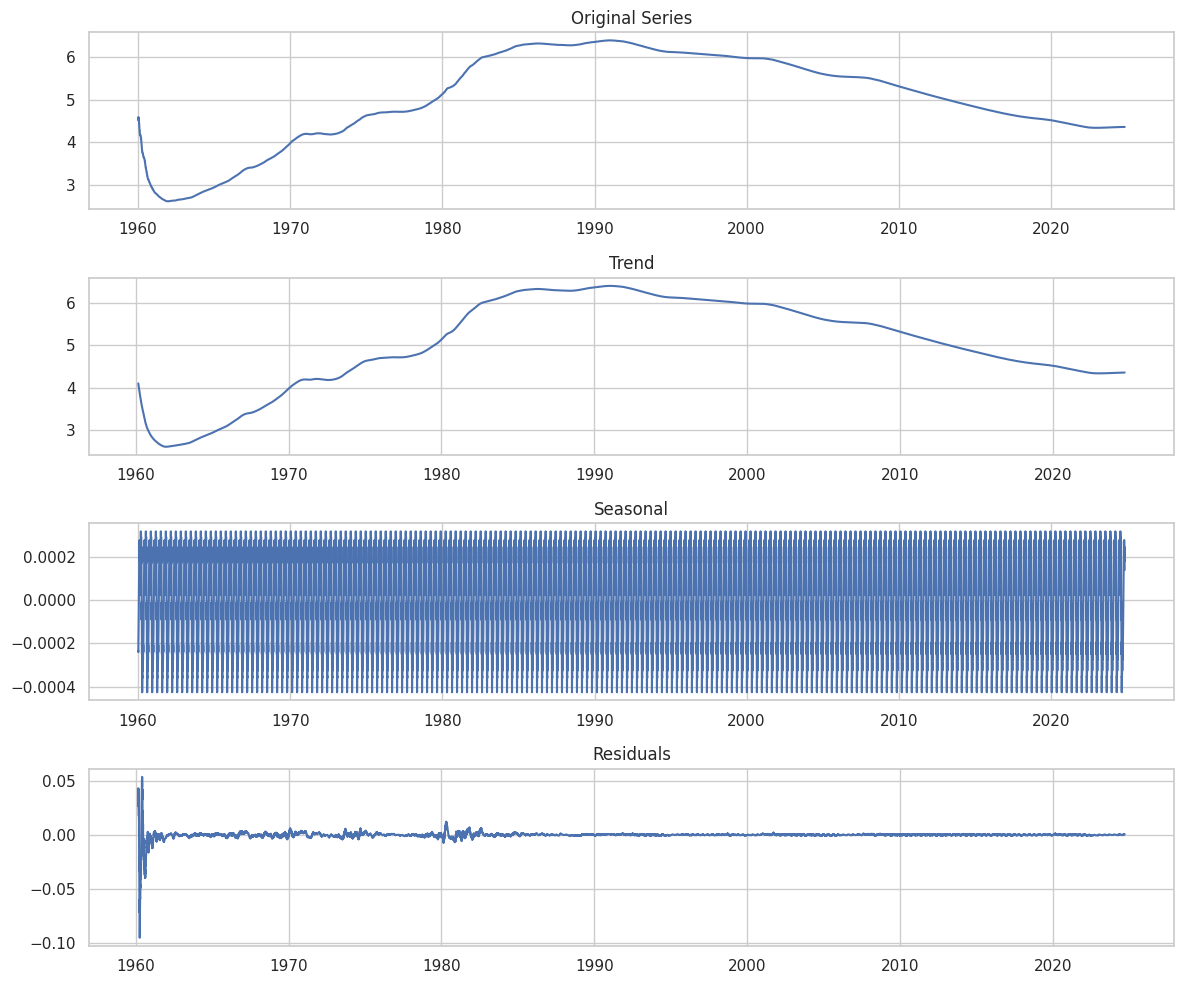

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Tiến hành phân tích theo mùa
result = seasonal_decompose(df['CMA30'], model='additive', period=12 * 10)

# Vẽ kết quả phân tích
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

# Biểu đồ chuỗi gốc
ax1.plot(df.index, df['CMA30'])
ax1.set_title('Original Series')

# Biểu đồ xu hướng
ax2.plot(df.index, result.trend)
ax2.set_title('Trend')

# Biểu đồ mùa vụ
ax3.plot(df.index, result.seasonal)
ax3.set_title('Seasonal')

# Biểu đồ phần dư
ax4.plot(df.index, result.resid)
ax4.set_title('Residuals')

plt.tight_layout()
plt.show()

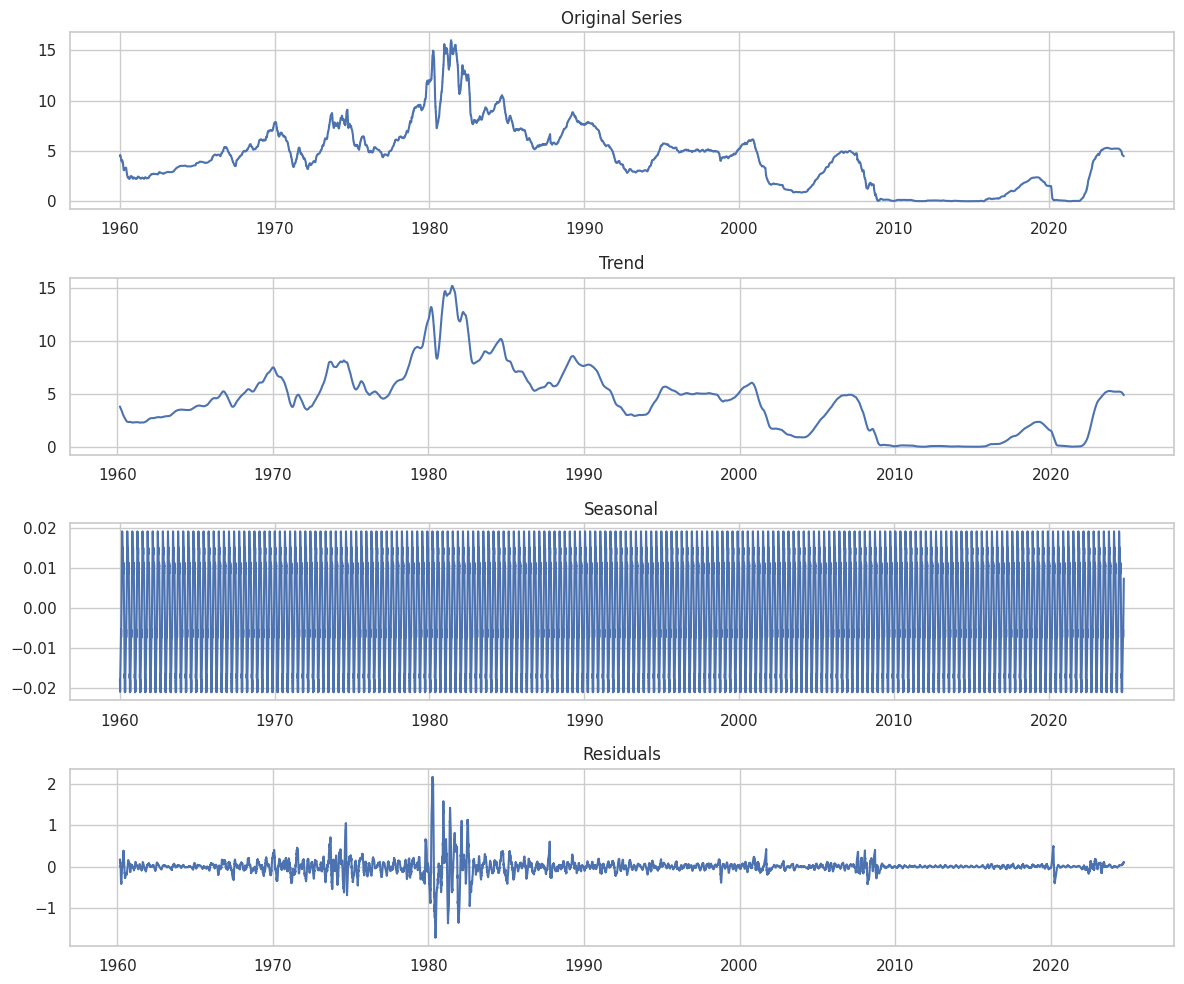

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Tiến hành phân tích theo mùa
result = seasonal_decompose(df['EWMA30'], model='additive', period=12 * 10)

# Vẽ kết quả phân tích
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

# Biểu đồ chuỗi gốc
ax1.plot(df.index, df['EWMA30'])
ax1.set_title('Original Series')

# Biểu đồ xu hướng
ax2.plot(df.index, result.trend)
ax2.set_title('Trend')

# Biểu đồ mùa vụ
ax3.plot(df.index, result.seasonal)
ax3.set_title('Seasonal')

# Biểu đồ phần dư
ax4.plot(df.index, result.resid)
ax4.set_title('Residuals')

plt.tight_layout()
plt.show()

ADF Statistic: -3.372964964048151
p-value: 0.011915752806962845
Chuỗi dừng (p-value < alpha).


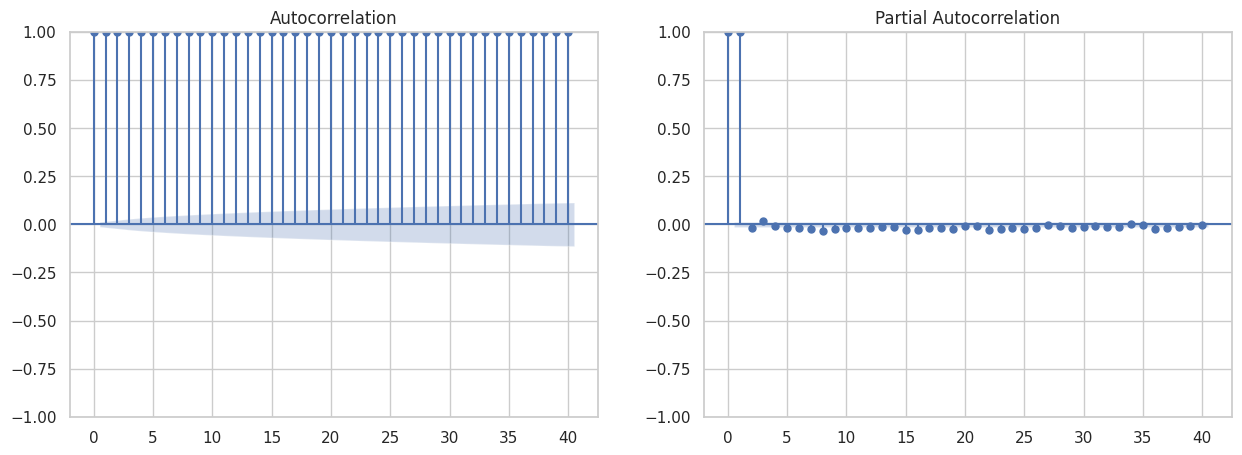

In [11]:
check_stationarity(df['CMA30'])
plot_acf_pacf(df['CMA30'])

ADF Statistic: -9.101357196180743
p-value: 3.598393018829132e-15
Chuỗi dừng (p-value < alpha).


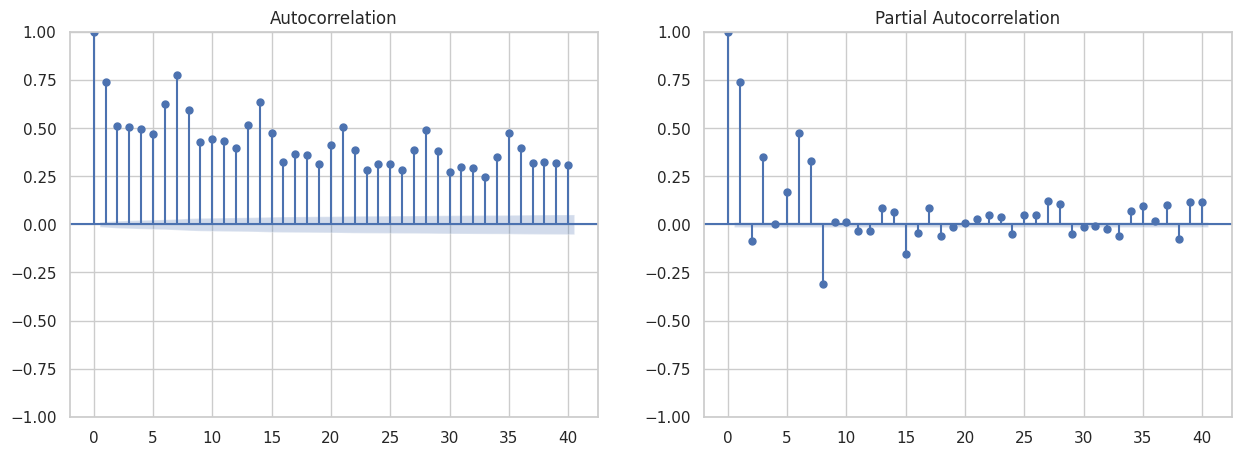

In [7]:
df['CMA30_diff'] = df['CMA30'].diff().dropna()
check_stationarity(df['CMA30_diff'])
plot_acf_pacf(df['CMA30_diff'])

ADF Statistic: -37.45511858469299
p-value: 0.0
Chuỗi dừng (p-value < alpha).


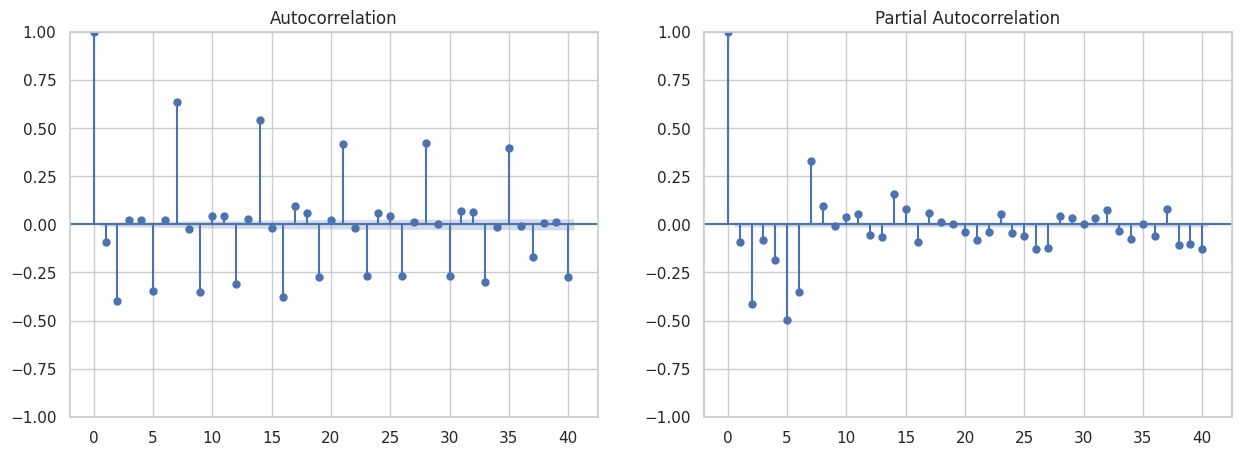

In [8]:
df['CMA30_diff2'] = df['CMA30_diff'].diff().dropna()
check_stationarity(df['CMA30_diff2'])
plot_acf_pacf(df['CMA30_diff2'])

ADF Statistic: -62.428246042309276
p-value: 0.0
Chuỗi dừng (p-value < alpha).


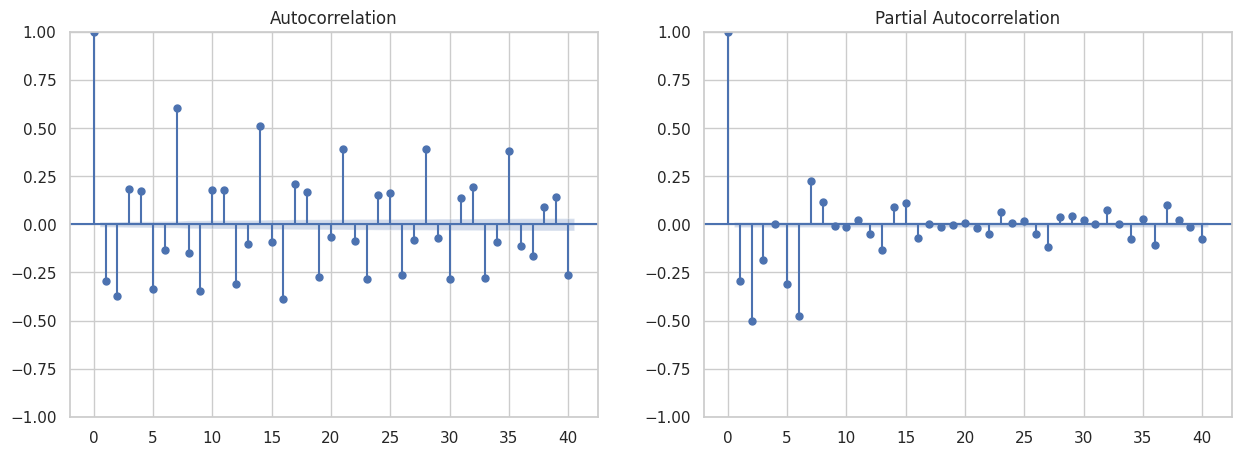

In [9]:
df['CMA30_diff3'] = df['CMA30_diff2'].diff().dropna()
check_stationarity(df['CMA30_diff3'])
plot_acf_pacf(df['CMA30_diff3'])

---

ARCH

In [10]:
df.head()

,Adj Close,Adj Close_diff,Adj Close_diff2,CMA30,EWMA30,CMA30_diff,CMA30_diff2,CMA30_diff3
Date,,,,,,,,
1960-01-04,4.52,NaN,NaN,4.520000,4.520000,NaN,NaN,NaN
1960-01-05,4.55,0.03,NaN,4.535000,4.535500,0.015000,NaN,NaN
1960-01-06,4.68,0.13,0.099999,4.583333,4.586912,0.048333,0.033333,NaN
1960-01-07,4.63,-0.05,-0.179999,4.595000,4.598785,0.011667,-0.036667,-0.070
1960-01-08,4.59,-0.04,0.010000,4.594000,4.596786,-0.001000,-0.012667,0.024


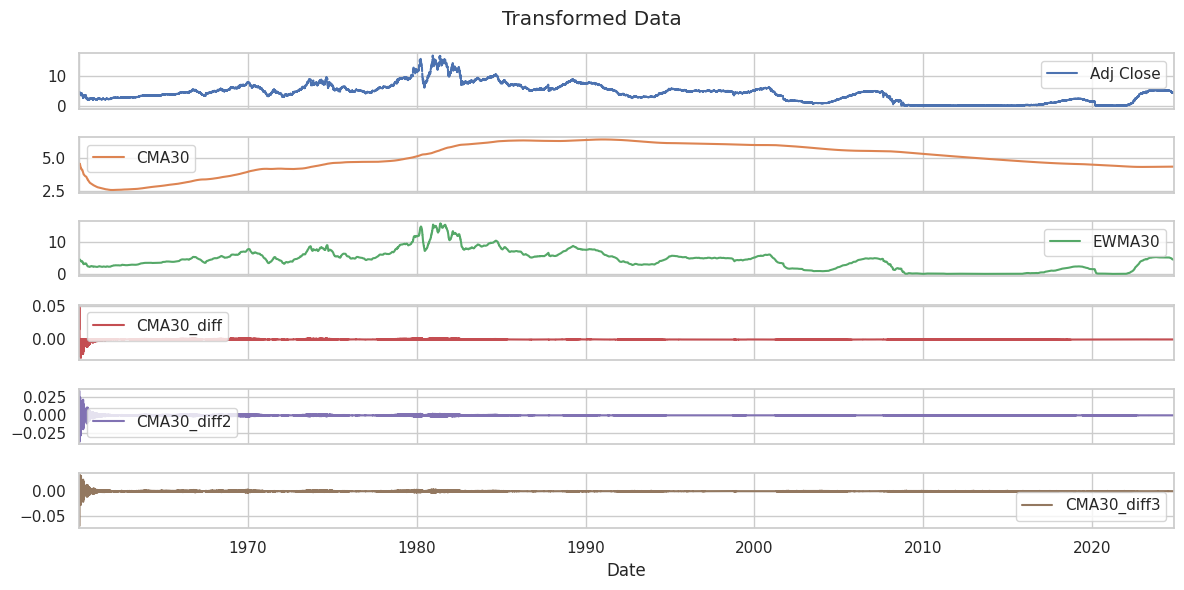

In [ ]:
import matplotlib.pyplot as plt

df[["Adj Close", "CMA30", "EWMA30", "CMA30_diff", "CMA30_diff2", "CMA30_diff3"]].plot(
    figsize=(12, 6), subplots=True, title="Transformed Data"
)
plt.tight_layout()
plt.show()

In [16]:
# Phân tích tính dừng
from statsmodels.tsa.stattools import adfuller

columns_to_test = ['Adj Close', 'CMA30', 'EWMA30', 'CMA30_diff', 'CMA30_diff2', 'CMA30_diff3']
for col in columns_to_test:
    result = adfuller(df[col].dropna())
    print(f"{col} - p-value: {result[1]} {'(Stationary)' if result[1] < 0.05 else '(Not Stationary)'}")




Adj Close - p-value: 0.15923852249623738 (Not Stationary)
CMA30 - p-value: 0.011915752806962845 (Stationary)
EWMA30 - p-value: 0.2217983079978148 (Not Stationary)
CMA30_diff - p-value: 3.598393018829132e-15 (Stationary)
CMA30_diff2 - p-value: 0.0 (Stationary)
CMA30_diff3 - p-value: 0.0 (Stationary)


In [ ]:
# # Tìm tham số tối ưu
# from statsmodels.tsa.arima.model import ARIMA

# best_model = None
# lowest_aic = float('inf')
# for col in ['Adj Close', 'CMA30_diff', 'CMA30_diff2']:
#     try:
#         model = ARIMA(df[col].dropna(), order=(2, 1, 2))
#         results = model.fit()
#         if results.aic < lowest_aic:
#             best_model = results
#             lowest_aic = results.aic
#     except:
#         pass

# if best_model:
#     print(best_model.summary())
#     best_model.plot_diagnostics(figsize=(12, 8))
#     plt.show()

Start use ARCH

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

# Dữ liệu: Lấy chuỗi lợi suất từ Adj Close
df['returns'] = df['Adj Close'].pct_change().dropna()

# 1. Kiểm tra heteroskedasticity bằng ARCH-LM test
lm_test = het_arch(df['returns'].dropna(), nlags=10)
print(f"ARCH-LM Test Statistic: {lm_test[0]}, p-value: {lm_test[1]}")

# Nếu p-value < 0.05, có heteroskedasticity => tiếp tục với ARCH/GARCH

ARCH-LM Test Statistic: 82.30135012268514, p-value: 1.7742198693956403e-13


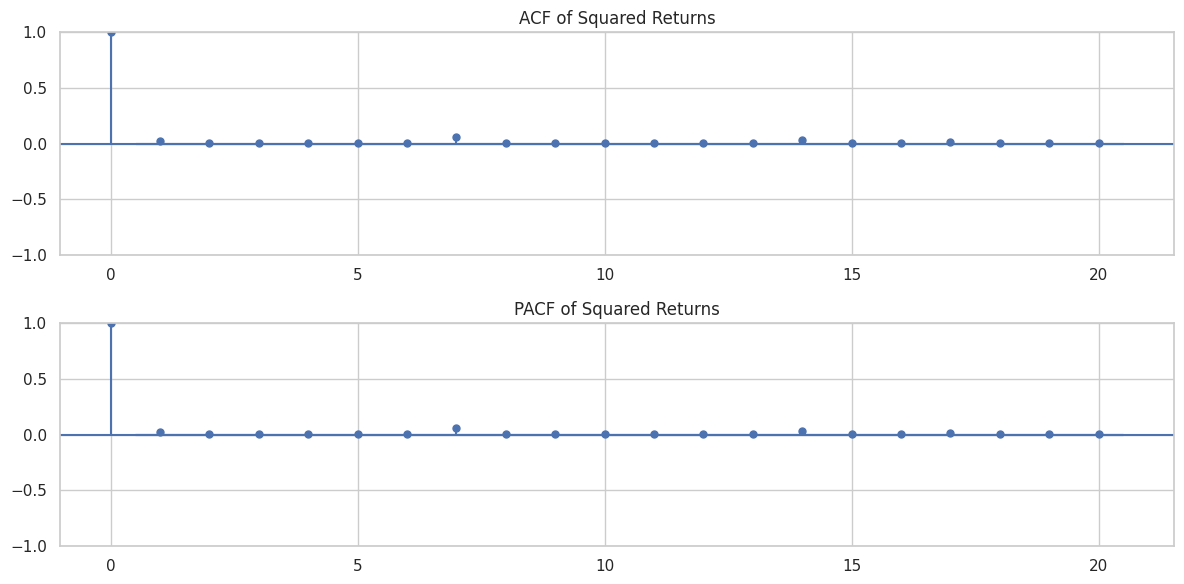

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Tính bình phương của chuỗi returns
squared_residuals = df['returns'].dropna() ** 2

# Vẽ ACF và PACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(squared_residuals, lags=20, ax=plt.gca(), title="ACF of Squared Returns")
plt.subplot(2, 1, 2)
plot_pacf(squared_residuals, lags=20, ax=plt.gca(), title="PACF of Squared Returns")
plt.tight_layout()
plt.show()


    ACF: Xem xét mức độ tự tương quan ở các độ trễ qq. Điều này giúp xác định qq (số độ trễ phương sai trong GARCH).
    PACF: Dùng để xác định pp (số độ trễ dư sai trong ARCH hoặc GARCH).

Lưu ý:

    Nếu ACF giảm dần, điều này gợi ý sử dụng GARCH.
    Nếu PACF có một số mũi nhọn rõ ràng, bạn có thể chọn bậc pp tương ứng.

In [27]:
from arch import arch_model

# ARCH(1)
model_arch_1 = arch_model(df['returns'].dropna(), vol='ARCH', p=1)
results_arch_1 = model_arch_1.fit()
print(f"ARCH(1): AIC = {results_arch_1.aic}, BIC = {results_arch_1.bic}")

# ARCH(2)
model_arch_2 = arch_model(df['returns'].dropna(), vol='ARCH', p=2)
results_arch_2 = model_arch_2.fit()
print(f"ARCH(2): AIC = {results_arch_2.aic}, BIC = {results_arch_2.bic}")

# GARCH(1, 1)
model_garch_1_1 = arch_model(df['returns'].dropna(), vol='Garch', p=1, q=1)
results_garch_1_1 = model_garch_1_1.fit()
print(f"GARCH(1,1): AIC = {results_garch_1_1.aic}, BIC = {results_garch_1_1.bic}")

# GARCH(2, 1)
model_garch_2_1 = arch_model(df['returns'].dropna(), vol='Garch', p=2, q=1)
results_garch_2_1 = model_garch_2_1.fit()
print(f"GARCH(2,1): AIC = {results_garch_2_1.aic}, BIC = {results_garch_2_1.bic}")


Iteration:      1,   Func. Count:      5,   Neg. LLF: 34840152007.755745
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3086383.3368451577
Iteration:      3,   Func. Count:     22,   Neg. LLF: -14853.581340637866
Iteration:      4,   Func. Count:     26,   Neg. LLF: -14677.39984286356
Iteration:      5,   Func. Count:     31,   Neg. LLF: -14859.259784009359
Iteration:      6,   Func. Count:     35,   Neg. LLF: -14859.259914878952
Iteration:      7,   Func. Count:     39,   Neg. LLF: -14859.259917802763
Iteration:      8,   Func. Count:     43,   Neg. LLF: 23808.354875940862
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14859.25991786897
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 8
ARCH(1): AIC = -29712.51983573794, BIC = -29688.302044091866
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4339103864.779517
Iteration:      2,   Func. Count:     18,   Neg. LLF: 8099029.812470571

In [ ]:
# Kiểm tra dư sai mô hình
residuals = results_garch_1_1.resid
from statsmodels.stats.diagnostic import het_arch
lm_test_resid = het_arch(residuals.dropna(), nlags=10)
print(f"ARCH-LM Test (Residuals): Statistic = {lm_test_resid[0]}, p-value = {lm_test_resid[1]}")

# p-value > 0.05: Không còn heteroskedasticity, mô hình là tốt.
# pp-value <= 0.05: Có thể cần thử mô hình phức tạp hơn hoặc kiểm tra lại giả thiết.


ARCH-LM Test (Residuals): Statistic = 82.20737736981657, p-value = 1.8513103648778936e-13


In [ ]:
# 2. Ước lượng mô hình ARCH/GARCH
# Thử ARCH(1)
model_arch = arch_model(df['returns'].dropna(), vol='ARCH', p=1)
results_arch = model_arch.fit(update_freq=5)
print('Arch:', results_arch.aic)
print(results_arch.summary())

print('\n----------------------------------------\n')
print('\n----------------------------------------\n')
print('\n----------------------------------------\n')

# Thử GARCH(1, 1)
model_garch = arch_model(df['returns'].dropna(), vol='Garch', p=1, q=1)
results_garch = model_garch.fit(update_freq=5)
print('Garch:', results_garch.aic)
print(results_garch.summary())

Iteration:      5,   Func. Count:     31,   Neg. LLF: -14859.259784009359
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14859.25991786897
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 8
Arch: -29712.51983573794
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                14859.3
Distribution:                  Normal   AIC:                          -29712.5
Method:            Maximum Likelihood   BIC:                          -29688.3
                                        No. Observations:                23685
Date:                Tue, Nov 19 2024   Df Residuals:                    23684
Time:                        19:43:22   Df Model:            

Mô hình ARCH khá tốt. Một số nhận xét về kết quả:

1. Mô hình Constant Mean - ARCH:
   - Trung bình có ý nghĩa thống kê (p-value < 0.05) và hợp lý với giá trị 0.00475.
   - Mô hình ARCH cũng có ý nghĩa thống kê với p-value < 0.001, cho thấy có sự không đồng nhất phương sai trong chuỗi dữ liệu.

2. Các chỉ số đánh giá mô hình:
   - Log-Likelihood cao (-14859.3), AIC và BIC thấp (-29712.5 và -29688.3) cho thấy mô hình khá tốt.
   - Hệ số R-squared và Adj. R-squared bằng 0, điều này phù hợp vì mô hình ARCH không dự báo giá trị trung bình mà chỉ mô hình hóa phương sai.

3. Ước tính các tham số:
   - Tham số omega (0.0145) và alpha1 (1.0000) đều có ý nghĩa thống kê, cho thấy mô hình ARCH phù hợp.
   - Giá trị alpha1 bằng 1 cho thấy sự dao động phương sai có tính chất bền vững (persistent volatility).

Nhìn chung, mô hình Constant Mean - ARCH có thể mô tả tốt tính chất không đồng nhất phương sai trong chuỗi dữ liệu. Có thể tiếp tục sử dụng mô hình này để dự báo phương sai có điều kiện cho chuỗi dữ liệu.

In [ ]:
# 3. Dự báo
forecast = results_garch.forecast(horizon=10)
print("Forecasted Variance (Next 10 Periods):")
print(forecast.variance[-1:])

Forecasted Variance (Next 10 Periods):
                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2024-11-08  0.004439  0.005325  0.006193  0.007044  0.007878  0.008695   

                h.07      h.08     h.09      h.10  
Date                                               
2024-11-08  0.009496  0.010281  0.01105  0.011803  


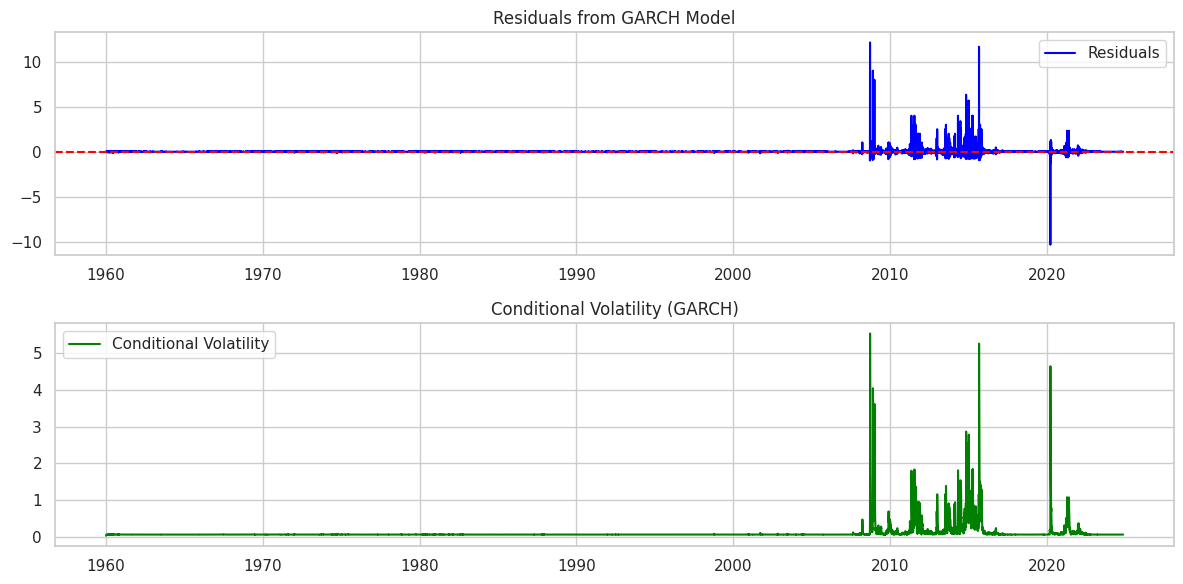

In [22]:
# 4. Đồ thị phân tích
plt.figure(figsize=(12, 6))

# Dư sai
plt.subplot(2, 1, 1)
plt.plot(results_garch.resid, label='Residuals', color='blue')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals from GARCH Model')
plt.legend()

# Phương sai có điều kiện
plt.subplot(2, 1, 2)
plt.plot(results_garch.conditional_volatility, label='Conditional Volatility', color='green')
plt.title('Conditional Volatility (GARCH)')
plt.legend()

plt.tight_layout()
plt.show()

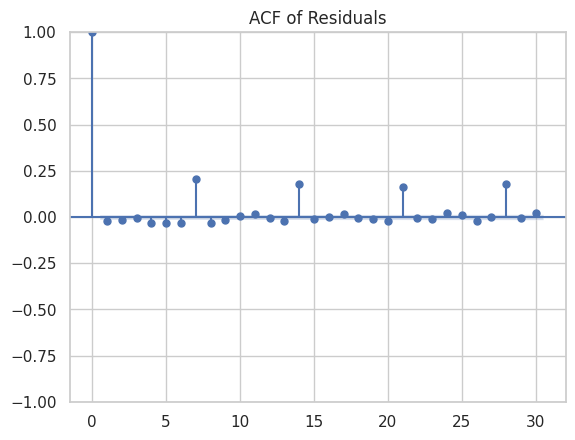

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(results_garch.resid, lags=30)
plt.title("ACF of Residuals")
plt.show()

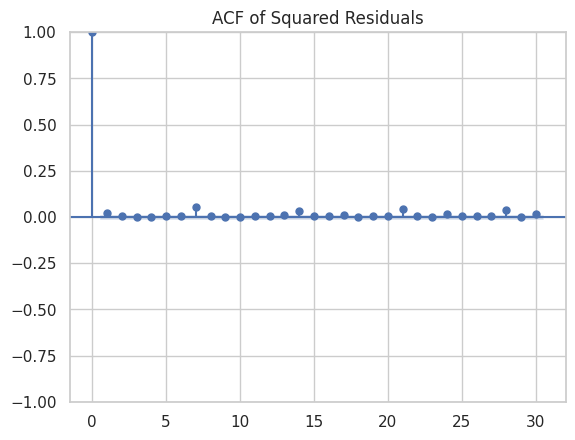

In [31]:
squared_residuals = results_garch.resid ** 2
plot_acf(squared_residuals, lags=30)
plt.title("ACF of Squared Residuals")
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, _, _ = het_arch(results_garch.resid)
print(f"ARCH-LM Test Statistic: {lm_stat}, p-value: {lm_pvalue}")

ARCH-LM Test Statistic: 82.20737736981657, p-value: 1.8513103648778936e-13


In [ ]:
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(results_garch.resid)
print(f"Jarque-Bera Test Statistic: {jb_stat}, p-value: {jb_pvalue}")

# p>0.05: Phần dư tuân theo phân phối chuẩn.
# p≤0.05p≤0.05: Phân phối chuẩn bị vi phạm, cần thử Student's tt.


Jarque-Bera Test Statistic: 1496064466.6128044, p-value: 0.0


--- 

LSTM

In [11]:
import pandas as pd

# Giả sử df là DataFrame chứa dữ liệu của bạn
df.fillna(method='bfill', inplace=True)  # Forward fill để điền giá trị thiếu


/tmp/ipykernel_565957/698964493.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Forward fill để điền giá trị thiếu


In [12]:
df.head()

,Adj Close,Adj Close_diff,Adj Close_diff2,CMA30,EWMA30,CMA30_diff,CMA30_diff2,CMA30_diff3
Date,,,,,,,,
1960-01-04,4.52,0.03,0.099999,4.520000,4.520000,0.015000,0.033333,-0.070
1960-01-05,4.55,0.03,0.099999,4.535000,4.535500,0.015000,0.033333,-0.070
1960-01-06,4.68,0.13,0.099999,4.583333,4.586912,0.048333,0.033333,-0.070
1960-01-07,4.63,-0.05,-0.179999,4.595000,4.598785,0.011667,-0.036667,-0.070
1960-01-08,4.59,-0.04,0.010000,4.594000,4.596786,-0.001000,-0.012667,0.024


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Chọn các cột bạn muốn sử dụng làm features
features = df[['Adj Close', 'Adj Close_diff', 'Adj Close_diff2', 'CMA30', 'EWMA30', 'CMA30_diff', 'CMA30_diff2', 'CMA30_diff3']].values

# Chuẩn hóa dữ liệu bằng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Hàm tạo các chuỗi thời gian để train
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 0])  # Dự đoán Adj Close (cột đầu tiên)
    return np.array(X), np.array(y)

# Chia dữ liệu thành train/test
time_step = 60  # Số ngày trước đó sẽ được sử dụng để dự báo ngày hôm nay
X, y = create_dataset(scaled_features, time_step)

# Chia dữ liệu thành train/test (ví dụ 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [14]:
import numpy as np

# Kiểm tra NaN hoặc inf trong dữ liệu
if np.any(np.isnan(scaled_features)) or np.any(np.isinf(scaled_features)):
    print("Dữ liệu chứa NaN hoặc inf")


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Xây dựng mô hình LSTM
model = Sequential()

# Thêm lớp LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Thêm lớp Dense để dự đoán giá trị
model.add(Dense(units=1))  # Chỉ dự đoán 1 giá trị (Adj Close)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=5, batch_size=12 * 10)


2024-11-19 20:32:21.285859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 20:32:21.295762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732023141.306363  565957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732023141.309652  565957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:32:21.322441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/5


2024-11-19 20:32:22.961141: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0161
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.4715e-04
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.8767e-04
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.3812e-04
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.0008e-04


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


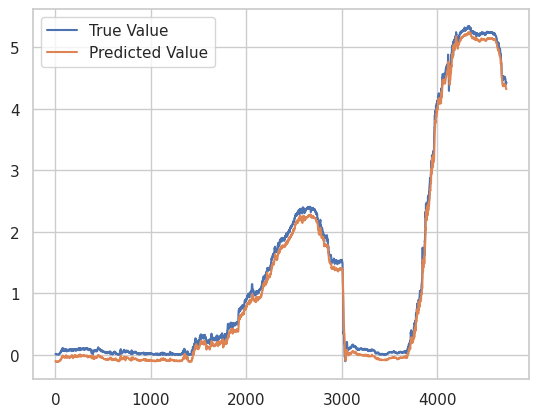

In [16]:
# Dự báo trên tập test
y_pred = model.predict(X_test)

# Chuyển đổi lại dữ liệu về giá trị gốc
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], scaled_features.shape[1]-1)))))
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_features.shape[1]-1)))))

# So sánh dự báo và giá trị thực tế
import matplotlib.pyplot as plt
plt.plot(y_test_rescaled[:, 0], label='True Value')
plt.plot(y_pred_rescaled[:, 0], label='Predicted Value')
plt.legend()
plt.show()


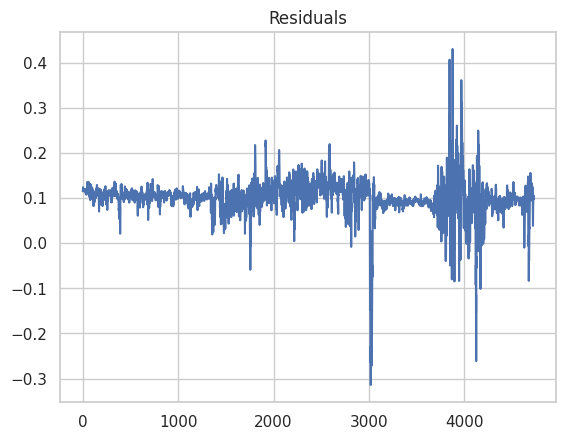

In [17]:
residuals = y_test_rescaled[:, 0] - y_pred_rescaled[:, 0]
plt.plot(residuals)
plt.title("Residuals")
plt.show()


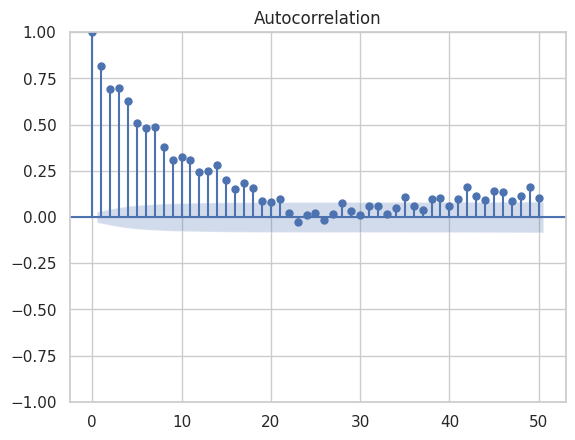

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=50)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipykernel_565957/2640266919.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_input[0, 0] = pred[0]  # Đặt giá trị dự báo cho 'Adj Close' vào cột đầu tiên


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

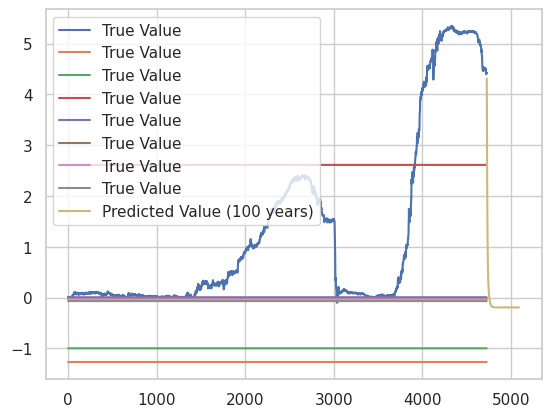

In [19]:
# Hàm dự báo cho các ngày tiếp theo
def predict_next_days(model, data, n_days, scaler, time_step=60):
    predictions = []
    
    # Lấy các dòng cuối cùng từ tập test làm dữ liệu đầu vào cho dự báo
    input_data = data[-time_step:]  # Dữ liệu đầu vào cho dự báo (dùng dữ liệu test gần nhất)
    
    for _ in range(n_days):
        # Dự báo giá trị 'Adj Close' cho ngày tiếp theo
        pred = model.predict(input_data.reshape(1, time_step, input_data.shape[1]))
        predictions.append(pred[0, 0])

        # Cập nhật input_data để chứa các dự báo trước đó và bỏ giá trị đầu tiên
        # Tạo mảng với pred[0] làm phần tử đầu và các phần tử còn lại là 0 cho các cột không phải 'Adj Close'
        new_input = np.zeros((1, input_data.shape[1]))  # Mảng 1x6, tất cả phần tử là 0
        new_input[0, 0] = pred[0]  # Đặt giá trị dự báo cho 'Adj Close' vào cột đầu tiên
        
        # Cập nhật dữ liệu đầu vào
        input_data = np.append(input_data[1:], new_input, axis=0)

    # Chuyển đổi các dự báo trở lại giá trị gốc
    predictions_rescaled = scaler.inverse_transform(np.hstack((np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), input_data.shape[1] - 1)))))
    return predictions_rescaled[:, 0]

# Dự báo 100 năm tiếp theo (36500 ngày)
# Số ngày trong 100 năm
days_in_100_years = 365 * 1
predicted_100_years = predict_next_days(model, scaled_features, days_in_100_years, scaler)


# Vẽ biểu đồ kết quả dự báo
import matplotlib.pyplot as plt

# Giả sử bạn có dữ liệu thực tế từ quá khứ (y_test_rescaled) và dữ liệu dự báo cho 100 năm (predicted_100_years)
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='True Value')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + len(predicted_100_years)), predicted_100_years, label='Predicted Value (100 years)')
plt.legend()
plt.show()



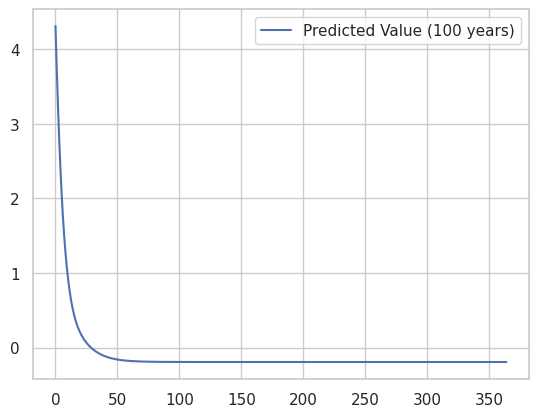

In [22]:
# Giả sử bạn có dữ liệu thực tế từ quá khứ (y_test_rescaled) và dữ liệu dự báo cho 100 năm (predicted_100_years)
# plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='True Value')
plt.plot(range(len(predicted_100_years)), predicted_100_years, label='Predicted Value (100 years)')
plt.legend()
plt.show()